### Importing libraries -

In [1]:
import sys
sys.path.append("timm-pytorch-image-models/pytorch-image-models-master")
#!pip3 install timm==0.5.4 

In [2]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import copy

import cv2
from tqdm import tqdm

import albumentations as A
from albumentations.pytorch import ToTensorV2

import timm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast, GradScaler
from torch.nn.modules.loss import _WeightedLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts

from sklearn.metrics import accuracy_score

In [3]:
timm.__version__

'0.5.4'

### Defining a config dictionary - 

In [4]:
config = {
    'img_size': 384,
    'epochs': 25,
    'learning_rate': 1e-3,
    'batch_size': 8,
    'wd_factor': 0.1,
    'wd_period': 7,
    'device': torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
}

### Function for plotting epochs v losses at the end -

In [5]:
def plot_results(train_loss, valid_loss):
    epochs = [i for i in range(1, len(train_loss)+1)]
    
    fig.set_size_inches(20, 10)
    
    plt.plot(epochs, train_loss, 'go-', label='Training Loss')
    plt.plot(epochs, valid_loss, 'ro-', label='Validation Loss')
    plt.title('Training & Validation (avg losses)')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    plt.show()

### Visualizing a few images -

In [6]:
print(os.listdir('hymenoptera_data'))
print(os.listdir(r'hymenoptera_data/train'))
print(os.listdir(r'hymenoptera_data/val'))

['train', 'val']
['ants', 'bees']
['ants', 'bees']


In [7]:
base_path = 'hymenoptera_data'
for dataset in os.listdir(base_path):
    print(f"Dataset: {dataset}")
    for category in os.listdir(os.path.join(base_path, dataset)):
        print(f"{category}: {len(os.listdir(os.path.join(os.path.join(base_path, dataset), category)))} images")

Dataset: train
ants: 125 images
bees: 121 images
Dataset: val
ants: 70 images
bees: 83 images


ANTS - 


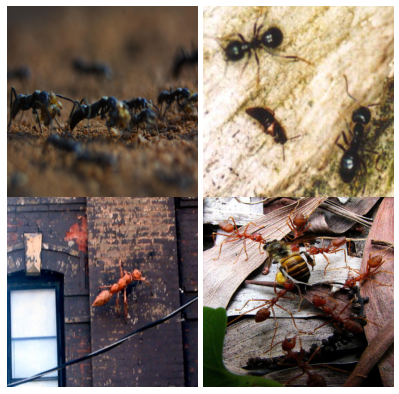

BEES - 


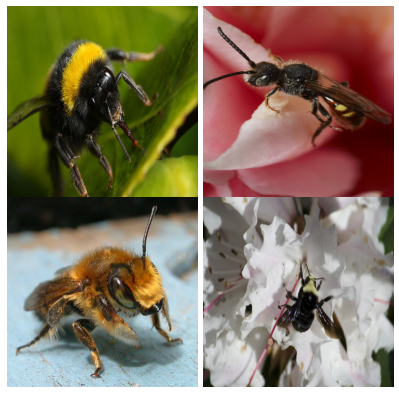

In [8]:
# Visualizing 4 random images for both classes - 
train_path = 'hymenoptera_data/train'
for category in ['ants', 'bees']:
    print(category.upper() + " - ")
    fig, ax = plt.subplots(2, 2)
    fig.set_size_inches(7, 7)
    imgs = random.sample(os.listdir(os.path.join(train_path, category)), 4)
    for i in range(2):
        for j in range(2):
            img = cv2.cvtColor(cv2.imread(os.path.join(os.path.join(train_path, category), imgs.pop(0))), cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (config['img_size'], config['img_size']))
            ax[i][j].imshow(img)
            ax[i][j].set_axis_off()
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

### Defining image augmentations for train and validation sets -

In [10]:
# for training data, augmentations related to rotations, flips and color changes might be helpful
# pad if needed will pad the image if one or both of its dimensions have number of pixels less than the corresponding resized dimension(384 here) 
augments = {
    'train': A.Compose([
        A.PadIfNeeded(min_height=config['img_size'], min_width=config['img_size'], p=1),
        A.RandomResizedCrop(config['img_size'], config['img_size']),
        A.Transpose(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(p=0.5),
        A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
        A.CoarseDropout(p=0.5),
        A.Cutout(p=0.5),
        ToTensorV2(p=1.0)
    ], p=1.0),
    
    'val':  A.Compose([
            A.PadIfNeeded(min_height=config['img_size'], min_width=config['img_size'], p=1),
            A.CenterCrop(config['img_size'], config['img_size'], p=1.0),
            A.Resize(config['img_size'], config['img_size'], p = 1.0),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
    ], p=1.0)
}

In [11]:
# Observe the change in shapes- 
img = cv2.cvtColor(cv2.imread("hymenoptera_data/train/ants/0013035.jpg"), cv2.COLOR_BGR2RGB)
print(img.shape)
print(augments['train'](image = img)['image'].shape)

(512, 768, 3)
torch.Size([3, 384, 384])


### Building the datasets and dataloaders -

In [12]:
train_img_paths = glob.glob('hymenoptera_data\\train\\*\\*.jpg')
val_img_paths = glob.glob('hymenoptera_data\\val\\*\\*.jpg')

df_train = pd.DataFrame(columns = ['img_path', 'img_class'], index = range(len(train_img_paths)))
df_train['img_path'] = train_img_paths
df_train['img_class'] = [int("ants" in i and "bees" not in i) for i in train_img_paths] # 1 for ants, 0 for bees

df_val = pd.DataFrame(columns = ['img_path', 'img_class'], index = range(len(val_img_paths)))
df_val['img_path'] = val_img_paths
df_val['img_class'] = [int("ants" in i and "bees" not in i) for i in val_img_paths]

In [13]:
# creating a cutom dataset class, to work with albumentations transform
class AntsvBeesDataset(Dataset):
    def __init__(self, df, is_train = True, img_transform = None):
        super().__init__()
        self.df = df
        self.is_train = is_train
        self.img_transform = img_transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img = cv2.cvtColor(cv2.imread(self.df['img_path'][idx]), cv2.COLOR_BGR2RGB)
        if self.img_transform:
            img = self.img_transform(image = img)['image']
        if self.is_train:
            label = self.df['img_class'][idx]
            return img, label
        return img

In [14]:
data_dirs = ['train', 'val']
img_datasets = {
    'train': AntsvBeesDataset(df = df_train, img_transform = augments['train']),
    'val': AntsvBeesDataset(df = df_val, img_transform = augments['val']),
}

img_dataloaders = {
    x: DataLoader(img_datasets[x], batch_size = config['batch_size'], shuffle = True, pin_memory = False, drop_last = False)
    for x in data_dirs
}

In [15]:
# Making sure, input to our model is of the shape - (batch_size, channels, height, width)
for i, j in img_dataloaders['train']:
    print(i.shape)
    break

torch.Size([8, 3, 384, 384])


In [16]:
dataset_sizes = {x: len(img_datasets[x]) for x in data_dirs}
class_names = ['ants', 'bees']

### Defining classes for each family of pre-trained models -

In [ ]:
#timm.list_models('*resnext*')

In [17]:
# conv_train indicates whether you want to keep the weights of the convolutional part of the network frozen or train them
class EfficientNetModel(nn.Module):
    def __init__(self, model_name = 'efficientnet_b4', num_classes = len(class_names), pretrained = True, conv_train = False):
        super(EfficientNetModel, self).__init__()
        self.pretrained_model = timm.create_model(model_name, pretrained = pretrained)
        if not conv_train:
            for param in self.pretrained_model.parameters():
                param.requires_grad = False
        self.new_fc_block = nn.Sequential(
                            nn.Linear(self.pretrained_model.classifier.out_features, 256),
                            nn.ReLU(),
                            nn.Dropout(p = 0.15),
                            nn.Linear(256, num_classes)
                            )
        
    def forward(self, x):
        x = self.pretrained_model(x)
        x = self.new_fc_block(x)
        return F.softmax(x, dim = 1)
    
    
class ResNeXtModel(nn.Module):
    def __init__(self, model_name = 'resnext101_32x8d', num_classes = len(class_names), pretrained = True, conv_train = False):
        super(ResNeXtModel, self).__init__()
        self.pretrained_model = timm.create_model(model_name, pretrained = pretrained)
        if not conv_train:
            for param in self.pretrained_model.parameters():
                param.requires_grad = False
        self.new_fc_block = nn.Sequential(
                            nn.Linear(self.pretrained_model.fc.out_features, 256),
                            nn.ReLU(),
                            nn.Dropout(p = 0.15),
                            nn.Linear(256, num_classes)
                            )
    
    def forward(self, x):
        x = self.pretrained_model(x)
        x = self.new_fc_block(x)
        return F.softmax(x, dim = 1)
    
    
class ConvNeXtModel(nn.Module):
    def __init__(self, model_name = 'convnext_base_384_in22ft1k', num_classes = len(class_names), pretrained = True, conv_train = False):
        super(ConvNeXtModel, self).__init__()
        self.pretrained_model = timm.create_model(model_name, pretrained = pretrained)
        if not conv_train:
            for param in self.pretrained_model.parameters():
                param.requires_grad = False
        self.new_fc_block = nn.Sequential(
                            nn.Linear(self.pretrained_model.head.fc.out_features, 256),
                            nn.ReLU(),
                            nn.Dropout(p = 0.15),
                            nn.Linear(256, num_classes)
                            )
        
    def forward(self, x):
        x = self.pretrained_model(x)
        x = self.new_fc_block(x)
        return F.softmax(x, dim = 1)
    
    
class VITModel(nn.Module):
    def __init__(self, model_name = 'vit_base_patch16_384', num_classes = len(class_names), pretrained = True, conv_train = False):
        super(VITModel, self).__init__()
        self.pretrained_model = timm.create_model(model_name, pretrained = pretrained)
        if not conv_train:
            for param in self.pretrained_model.parameters():
                param.requires_grad = False
        self.new_fc_block = nn.Sequential(
                            nn.Linear(self.pretrained_model.head.out_features, 256),
                            nn.ReLU(),
                            nn.Dropout(p = 0.15),
                            nn.Linear(256, num_classes)
                            )
        
    def forward(self, x):
        x = self.pretrained_model(x)
        x = self.new_fc_block(x)
        return F.softmax(x, dim = 1)
    
    
class XceptionModel(nn.Module):
    def __init__(self, model_name = 'xception71', num_classes = len(class_names), pretrained = True, conv_train = False):
        super(XceptionModel, self).__init__()
        self.pretrained_model = timm.create_model(model_name, pretrained = pretrained)
        if not conv_train:
            for param in self.pretrained_model.parameters():
                param.requires_grad = False
        self.new_fc_block = nn.Sequential(
                            nn.Linear(self.pretrained_model.head.fc.out_features, 256),
                            nn.ReLU(),
                            nn.Dropout(p = 0.15),
                            nn.Linear(256, num_classes)
                            )
        
    def forward(self, x):
        x = self.pretrained_model(x)
        x = self.new_fc_block(x)
        return F.softmax(x, dim = 1)
    
    
class InceptionModel(nn.Module):
    def __init__(self, model_name = 'inception_v4', num_classes = len(class_names), pretrained = True, conv_train = False):
        super(InceptionModel, self).__init__()
        self.pretrained_model = timm.create_model(model_name, pretrained = pretrained)
        if not conv_train:
            for param in self.pretrained_model.parameters():
                param.requires_grad = False
        self.new_fc_block = nn.Sequential(
                            nn.Linear(self.pretrained_model.last_linear.out_features, 256),
                            nn.ReLU(),
                            nn.Dropout(p = 0.15),
                            nn.Linear(256, num_classes)
                            )
                
    def forward(self, x):
        x = self.pretrained_model(x)
        x = self.new_fc_block(x)
        return F.softmax(x, dim = 1)

### Train and eval functions - 

In [18]:
def train_model(model, loss_fn, scaler, optimizer, scheduler, num_epochs = 25, patience = 3):
    best_model_wts = copy.deepcopy(model.state_dict())
    lowest_val_loss, best_val_acc, best_model_epoch = float('inf'), 0.0, 0
    rounds_no_improve = 0 # num of consecutive rounds in which validation loss didn't improve
    train_losses, val_losses = [], []
    
    for epoch in range(num_epochs):
        print(f"{'-'*25} EPOCH: {epoch + 1}/{num_epochs} {'-'*25}")
        model.train()
        running_loss = 0
        train_prog_bar = tqdm(img_dataloaders['train'], total = len(img_dataloaders['train']))
        for batch_X, batch_y in train_prog_bar:
            batch_X, batch_y = batch_X.to(config['device']).float(), batch_y.to(config['device']).long()
            optimizer.zero_grad()
            with autocast():
                outputs = model(batch_X); preds = torch.argmax(outputs, 1)
                batch_loss = loss_fn(outputs, batch_y)
            scaler.scale(batch_loss).backward()
            scaler.step(optimizer)
            scaler.update()
            running_loss += batch_loss.detach().item()
            batch_acc = accuracy_score(batch_y.cpu().numpy(), preds.cpu().numpy())
            train_pbar_desc = f'loss: {batch_loss.detach().item():.4f}, acc: {batch_acc:.4f}'
            train_prog_bar.set_description(desc = train_pbar_desc)
        scheduler.step()
        avg_batch_loss = running_loss / len(img_dataloaders['train'])
        train_losses.append(avg_batch_loss)
        print(f"Avg batch loss(train): {avg_batch_loss:.4f}")
        del batch_X, batch_y, outputs, preds
        
        val_loss, val_acc = eval_model(model, loss_fn)
        val_losses.append(val_loss)
        
        if epoch > 0:
            if val_loss >= lowest_val_loss:
                rounds_no_improve += 1
            else:
                rounds_no_improve = 0
            if rounds_no_improve == patience:
                break
        
        if val_loss < lowest_val_loss:
            lowest_val_loss = val_loss
            best_val_acc = val_acc
            best_model_epoch = epoch + 1
            best_model_wts = copy.deepcopy(model.state_dict())
            
        torch.cuda.empty_cache()
    
    print("\n")
    print("Best model -")
    print(f"Epoch: {best_model_epoch}")
    model.load_state_dict(best_model_wts)
    eval_model(model, loss_fn, for_data = 'train')    
    print(f"Validation accuracy: {best_val_acc}")
    return (model, train_losses, val_losses)

In [19]:
def eval_model(model, loss_fn, for_data = 'val'):
    model.eval()
    running_loss = 0
    running_corrects = 0
    eval_prog_bar = tqdm(img_dataloaders[for_data], total = len(img_dataloaders[for_data]))
    with torch.no_grad():
        for batch_X, batch_y in eval_prog_bar:
            batch_X, batch_y = batch_X.to(config['device']).float(), batch_y.to(config['device']).long()
            outputs = model(batch_X); preds = torch.argmax(outputs, 1)
            if for_data == 'val':
                batch_loss = loss_fn(outputs, batch_y)
                running_loss += batch_loss.detach().item()
                batch_acc = accuracy_score(batch_y.cpu().numpy(), preds.cpu().numpy())
                eval_pbar_desc = f'loss: {batch_loss.detach().item():.4f}, acc: {batch_acc:.4f}'
                eval_prog_bar.set_description(desc = eval_pbar_desc)
            running_corrects += torch.sum(batch_y == preds).item()
        del batch_X, batch_y, outputs, preds
        epoch_acc = running_corrects / dataset_sizes[for_data]
        print(f"{for_data.capitalize()} accuracy: {epoch_acc:.4f}")
        if for_data == 'val':
            avg_batch_loss = running_loss / len(img_dataloaders['val'])
            print(f"Avg batch loss(val): {avg_batch_loss:.4f}")
            return avg_batch_loss, epoch_acc
        return

------------------------- EPOCH: 1/25 -------------------------


loss: 0.4556, acc: 0.7500: 100%|██████████| 31/31 [00:12<00:00,  2.50it/s]


Avg batch loss(train): 0.3686


loss: 0.3133, acc: 1.0000: 100%|██████████| 20/20 [00:06<00:00,  2.88it/s]


Val accuracy: 1.0000
Avg batch loss(val): 0.3186
------------------------- EPOCH: 2/25 -------------------------


loss: 0.3133, acc: 1.0000: 100%|██████████| 31/31 [00:07<00:00,  4.40it/s]


Avg batch loss(train): 0.3340


loss: 0.3133, acc: 1.0000: 100%|██████████| 20/20 [00:06<00:00,  3.33it/s]


Val accuracy: 1.0000
Avg batch loss(val): 0.3166
------------------------- EPOCH: 3/25 -------------------------


loss: 0.3133, acc: 1.0000: 100%|██████████| 31/31 [00:07<00:00,  4.37it/s]


Avg batch loss(train): 0.3329


loss: 0.3133, acc: 1.0000: 100%|██████████| 20/20 [00:06<00:00,  3.32it/s]


Val accuracy: 1.0000
Avg batch loss(val): 0.3163
------------------------- EPOCH: 4/25 -------------------------


loss: 0.3133, acc: 1.0000: 100%|██████████| 31/31 [00:07<00:00,  4.28it/s]


Avg batch loss(train): 0.3368


loss: 0.3133, acc: 1.0000: 100%|██████████| 20/20 [00:06<00:00,  3.33it/s]


Val accuracy: 0.9935
Avg batch loss(val): 0.3163
------------------------- EPOCH: 5/25 -------------------------


loss: 0.3133, acc: 1.0000: 100%|██████████| 31/31 [00:07<00:00,  4.35it/s]


Avg batch loss(train): 0.3308


loss: 0.3133, acc: 1.0000: 100%|██████████| 20/20 [00:05<00:00,  3.34it/s]


Val accuracy: 1.0000
Avg batch loss(val): 0.3138
------------------------- EPOCH: 6/25 -------------------------


loss: 0.3133, acc: 1.0000: 100%|██████████| 31/31 [00:07<00:00,  4.41it/s]


Avg batch loss(train): 0.3411


loss: 0.3133, acc: 1.0000: 100%|██████████| 20/20 [00:06<00:00,  3.31it/s]


Val accuracy: 0.9935
Avg batch loss(val): 0.3175
------------------------- EPOCH: 7/25 -------------------------


loss: 0.3133, acc: 1.0000: 100%|██████████| 31/31 [00:07<00:00,  4.34it/s]


Avg batch loss(train): 0.3194


loss: 0.3133, acc: 1.0000: 100%|██████████| 20/20 [00:06<00:00,  3.29it/s]


Val accuracy: 1.0000
Avg batch loss(val): 0.3135
------------------------- EPOCH: 8/25 -------------------------


loss: 0.3133, acc: 1.0000: 100%|██████████| 31/31 [00:07<00:00,  4.37it/s]


Avg batch loss(train): 0.3292


loss: 0.3133, acc: 1.0000: 100%|██████████| 20/20 [00:06<00:00,  3.30it/s]


Val accuracy: 1.0000
Avg batch loss(val): 0.3137
------------------------- EPOCH: 9/25 -------------------------


loss: 0.3133, acc: 1.0000: 100%|██████████| 31/31 [00:07<00:00,  4.35it/s]


Avg batch loss(train): 0.3233


loss: 0.3133, acc: 1.0000: 100%|██████████| 20/20 [00:06<00:00,  3.31it/s]


Val accuracy: 1.0000
Avg batch loss(val): 0.3137
------------------------- EPOCH: 10/25 -------------------------


loss: 0.3133, acc: 1.0000: 100%|██████████| 31/31 [00:07<00:00,  4.33it/s]


Avg batch loss(train): 0.3392


loss: 0.3133, acc: 1.0000: 100%|██████████| 20/20 [00:06<00:00,  3.30it/s]


Val accuracy: 1.0000
Avg batch loss(val): 0.3142


Best model -
Epoch: 7


100%|██████████| 31/31 [00:10<00:00,  3.05it/s]


Train accuracy: 0.9836
Validation accuracy: 1.0




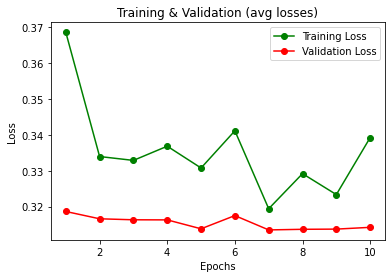

In [20]:
model = ConvNeXtModel().to(config['device'])
loss_fn = nn.CrossEntropyLoss()
scaler = GradScaler()
optimizer = optim.Adam(model.new_fc_block.parameters(), lr = config['learning_rate'])
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = config['wd_period'], gamma = config['wd_factor'])

best_model, train_losses, val_losses = train_model(model, loss_fn, scaler, optimizer, scheduler)
print("\n")
plot_results(train_losses, val_losses)

#### Characteristics of the above early stopping implementation - 
##### > Considers **consecutive** rounds of no improvement
##### > Compares current epoch's validation loss with the lowest validation loss of all the epochs before and not just with the previous epoch's loss

#### Some observations - 
##### Epochs e1 and e2 have losses l1 and l2 and e1 came before e2 . If l2 is more than l1 doesn't mean the accuracy of e2 will always be less than accuracy of e1, it can be the same or even more sometimes .
##### best_val_acc doesn't necessarily mean highest val acc . Best acc and best epoch is defined in terms of lowest val loss and lowest val loss always doesn't mean highest val acc  

### Saving the best model - 

In [21]:
# Saving the state_dict of the best model and not the entire model
PATH = "AntsVBees_BestModel_ConvNeXt.pth"
torch.save(best_model.state_dict(), PATH)

### Loading the best model and making some inferences(predictions) -

In [22]:
# Since we only saved the state_dict i.e., the learned parameters , we'll have to create an object of the model's class and then load the state_dict
# torch.load(PATH) will deserialize the saved state dict, so we can't do something like - model.load_state_dict(PATH)
model = ConvNeXtModel()
model.load_state_dict(torch.load("AntsVBees_BestModel_ConvNeXt.pth"))
model.eval()

ConvNeXtModel(
  (pretrained_model): ConvNeXt(
    (stem): Sequential(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
    )
    (stages): Sequential(
      (0): ConvNeXtStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): ConvNeXtBlock(
            (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
            (norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=128, out_features=512, bias=True)
              (act): GELU()
              (drop1): Dropout(p=0.0, inplace=False)
              (fc2): Linear(in_features=512, out_features=128, bias=True)
              (drop2): Dropout(p=0.0, inplace=False)
            )
            (drop_path): Identity()
          )
          (1): ConvNeXtBlock(
            (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), 

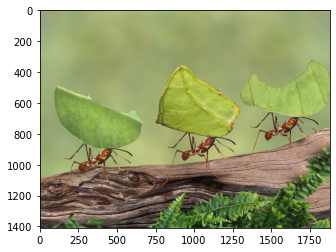

ants




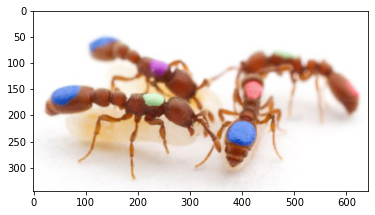

ants




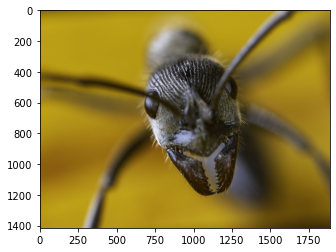

ants




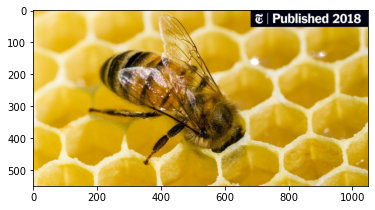

bees




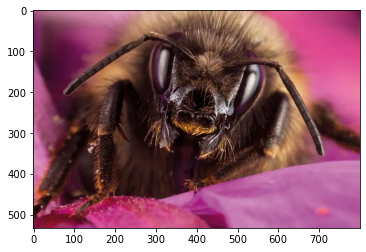

bees




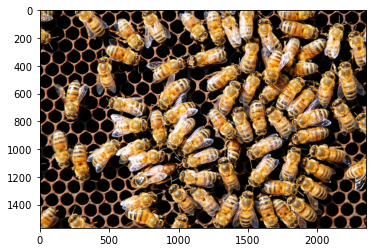

bees




In [23]:
inference_path = "Images_for_inference" # there are 6 images for testing, 3 each of ants and bees
for img_name in os.listdir(inference_path):
    img_path = os.path.join(inference_path, img_name) # get the image path
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB) # read the image in correct format
    output = model(augments['val'](image = img)['image'].view(-1, 3, config['img_size'], config['img_size'])) # augmentation,resizing & forward pass
    pred = torch.argmax(output, 1) # generate predictions 
    plt.imshow(img)  
    plt.show()
    print("ants" if pred.item() == 1 else "bees") # 1 for ants, 0 for bees
    print("\n")

#### So our model correctly predicts on all the test images !